Load and explore the dataset

In [5]:
import pandas as pd

# Load the dataset
file_path = "/content/E-commerce_data.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to understand the structure of the dataset
xls.sheet_names


['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']

In [6]:
# Load and display the first few rows of each sheet
data_samples = {sheet: xls.parse(sheet).head() for sheet in xls.sheet_names}
data_samples


{'customers':    customer_id  join_date  city_id  gender_id
 0            1 2022-01-08        7          1
 1            2 2023-05-02       20          2
 2            3 2023-05-14       15          1
 3            4 2022-11-25       11          2
 4            5 2023-04-26        8          1,
 'genders':    gender_id gender_name
 0          1        Male
 1          2      Female,
 'cities':    city_id         city_name
 0        1             Cairo
 1        2        Alexandria
 2        3              Giza
 3        4  Shubra El-Kheima
 4        5         Port Said,
 'transactions':    transaction_id  customer_id transaction_date transaction_status  \
 0               1          733       2024-05-11         subscribed   
 1               2          631       2023-05-15             burned   
 2               3          309       2022-11-13         subscribed   
 3               4          695       2024-01-26         subscribed   
 4               5          288       2022-10-12    

In [7]:
# Load full datasets
customers = xls.parse("customers")
transactions = xls.parse("transactions")

# Convert date columns to datetime format
customers["join_date"] = pd.to_datetime(customers["join_date"])
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
transactions["burn_date"] = pd.to_datetime(transactions["burn_date"])

# Define the reference date for Recency calculation (latest transaction date)
reference_date = transactions["transaction_date"].max()

# Compute RFM metrics
rfm = transactions.groupby("customer_id").agg(
    Recency=("transaction_date", lambda x: (reference_date - x.max()).days),
    Frequency=("transaction_id", "count"),
    Monetary=("burn_date", lambda x: x.notna().sum())  # Count only successful coupon burns
).reset_index()

# Display the first few rows of the RFM dataset
rfm.head()


,customer_id,Recency,Frequency,Monetary
0,1,49,7,3
1,2,267,3,1
2,3,9,5,1
3,4,546,1,0
4,5,12,4,3


Elbow Method

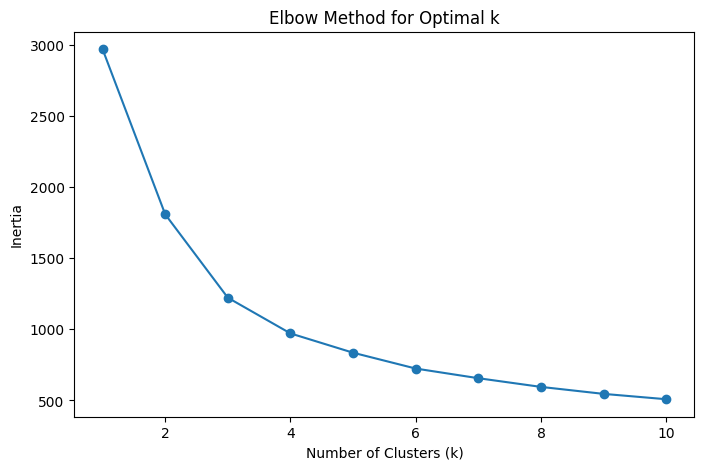

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Standardize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

# Determine optimal clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [9]:
# Based on the Elbow Method, choosing k=4 (or as observed from the bend)
optimal_k = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Display the first few rows with cluster labels
rfm.head()


,customer_id,Recency,Frequency,Monetary,Cluster
0,1,49,7,3,3
1,2,267,3,1,2
2,3,9,5,1,1
3,4,546,1,0,2
4,5,12,4,3,3


In [10]:
# Compute summary statistics for each cluster
cluster_summary = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(2)

# Count the number of customers in each cluster
cluster_summary["Customer_Count"] = rfm["Cluster"].value_counts()

# Display the cluster characteristics
cluster_summary


,Recency,Frequency,Monetary,Customer_Count
Cluster,,,,
0,49.23,8.24,4.89,175
1,71.19,3.17,1.13,290
2,408.14,3.01,1.63,114
3,70.67,5.60,2.80,410


Model Development

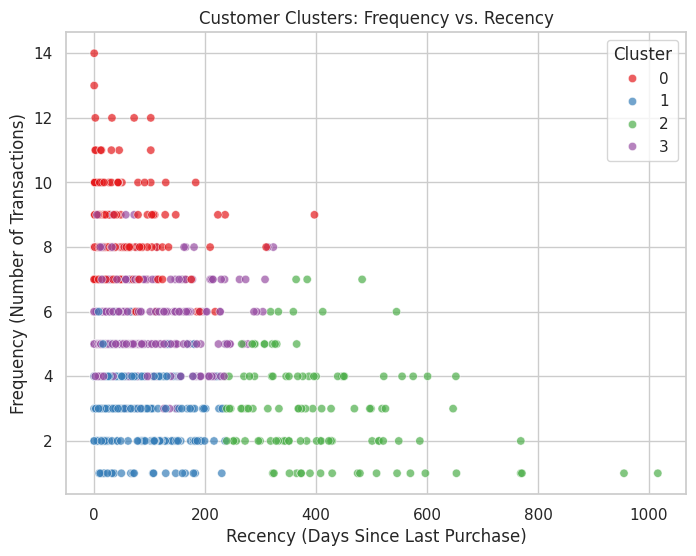

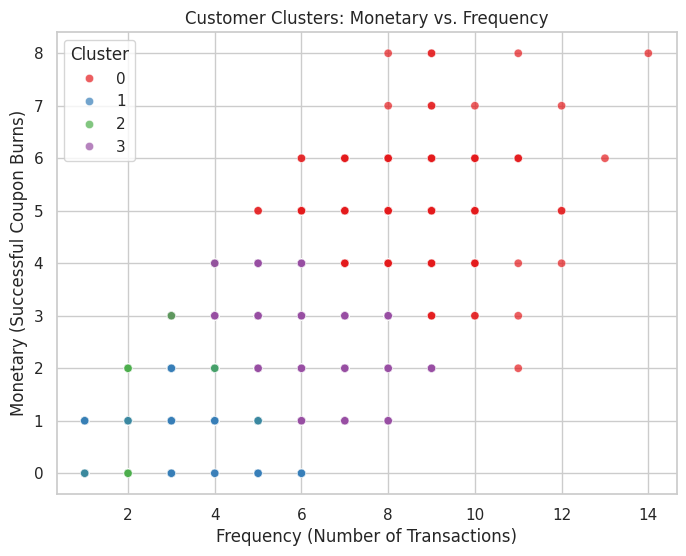

In [11]:
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot Frequency vs. Recency with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="Cluster", palette="Set1", alpha=0.7)
plt.title("Customer Clusters: Frequency vs. Recency")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Frequency (Number of Transactions)")
plt.legend(title="Cluster")
plt.show()

# Plot Monetary vs. Frequency with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="Set1", alpha=0.7)
plt.title("Customer Clusters: Monetary vs. Frequency")
plt.xlabel("Frequency (Number of Transactions)")
plt.ylabel("Monetary (Successful Coupon Burns)")
plt.legend(title="Cluster")
plt.show()


Hierarchical Clustering Results

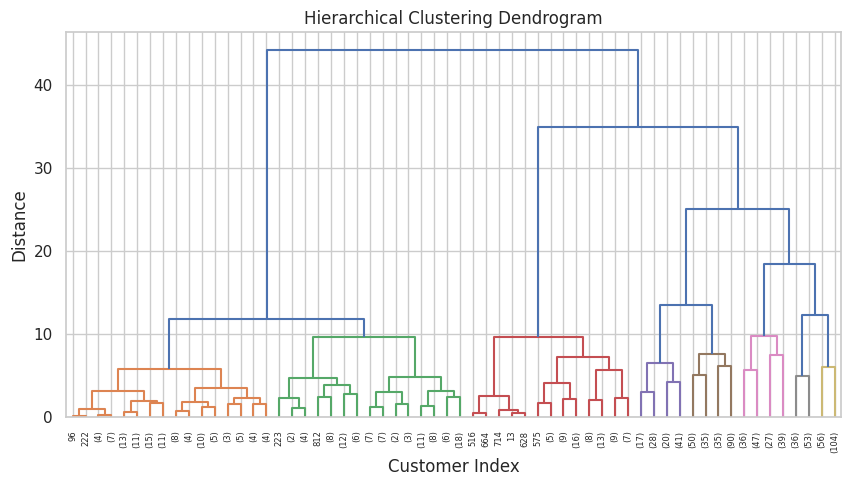

,Recency,Frequency,Monetary,Customer_Count
Hierarchical_Cluster,,,,
1,43.40,7.91,4.77,202
2,470.10,2.41,1.22,73
3,54.20,3.44,1.24,316
4,111.93,5.37,2.69,398


In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(rfm_scaled, method="ward")

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, truncate_mode="level", p=5, color_threshold=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customer Index")
plt.ylabel("Distance")
plt.show()

# Assign clusters based on the dendrogram (choosing 4 clusters for comparison)
rfm["Hierarchical_Cluster"] = fcluster(linkage_matrix, optimal_k, criterion="maxclust")

# Display cluster summary statistics for Hierarchical Clustering
hierarchical_summary = rfm.groupby("Hierarchical_Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(2)
hierarchical_summary["Customer_Count"] = rfm["Hierarchical_Cluster"].value_counts()

hierarchical_summary


Load the 'genders' sheet

In [13]:
# Load the 'genders' sheet again and check its columns
genders = xls.parse("genders")
genders.head()


,gender_id,gender_name
0,1,Male
1,2,Female


Display cluster details

In [15]:
# Based on the Elbow Method, selecting the optimal number of clusters (e.g., 3 or 4)
optimal_k = 4

scaled_data = rfm_scaled  # Assign rfm_scaled to scaled_data

# 2. Apply K-Means clustering and assign the cluster labels to a new column in 'customer_features'
cluster_labels = kmeans.fit_predict(scaled_data)

customer_features = pd.DataFrame(scaled_data)  # Assuming scaled_data is a numpy array
customer_features["cluster"] = cluster_labels

# Analyze cluster distribution
cluster_counts = customer_features["cluster"].value_counts()
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Convert back to original scale

# Display cluster details
cluster_counts, cluster_centers


(cluster
 3    410
 1    290
 0    175
 2    114
 Name: count, dtype: int64,
 array([[ 49.22857143,   8.24      ,   4.89142857],
        [ 71.1862069 ,   3.16551724,   1.13103448],
        [408.14035088,   3.00877193,   1.63157895],
        [ 70.66585366,   5.60243902,   2.79512195]]))

Feature Selection

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
file_path = "/content/E-commerce_data.xlsx"
xls = pd.ExcelFile(file_path)

# Load relevant sheets
customers = xls.parse("customers")
genders = xls.parse("genders")
cities = xls.parse("cities")
transactions = xls.parse("transactions")

# Merge datasets
data = customers.merge(genders.rename(columns={"gender_name": "gender"}), on="gender_id", how="left") \
                .merge(cities, on="city_id", how="left") \
                .merge(transactions, on="customer_id", how="left")

# Convert transaction date to datetime
data["transaction_date"] = pd.to_datetime(data["transaction_date"])

# Feature Engineering
rfm = data.groupby("customer_id").agg(
    Recency=("transaction_date", lambda x: (x.max() - x.min()).days),
    Frequency=("transaction_id", "count"),
    Monetary=("burn_date", lambda x: x.notna().sum()),
    Gender=("gender", "first"),
    City=("city_name", "first"),
    Coupon_Usage_Freq=("coupon_name", "count"),
    Transaction_Status=("transaction_status", "first")
).reset_index()

# Encode categorical features
le_gender = LabelEncoder()
le_city = LabelEncoder()
le_status = LabelEncoder()
rfm["Gender"] = le_gender.fit_transform(rfm["Gender"])
rfm["City"] = le_city.fit_transform(rfm["City"])
rfm["Transaction_Status"] = le_status.fit_transform(rfm["Transaction_Status"])

# Standardize numerical features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary", "Gender", "City", "Coupon_Usage_Freq", "Transaction_Status"]])

Display evaluation metrics

In [17]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score
silhouette_avg = silhouette_score(scaled_data, customer_features["cluster"])

# Get Inertia (already computed in K-Means)
inertia_score = kmeans.inertia_

# Display evaluation metrics
silhouette_avg, inertia_score


(0.31583846495201334, 971.0991993168454)

Create a DataFrame for visualization

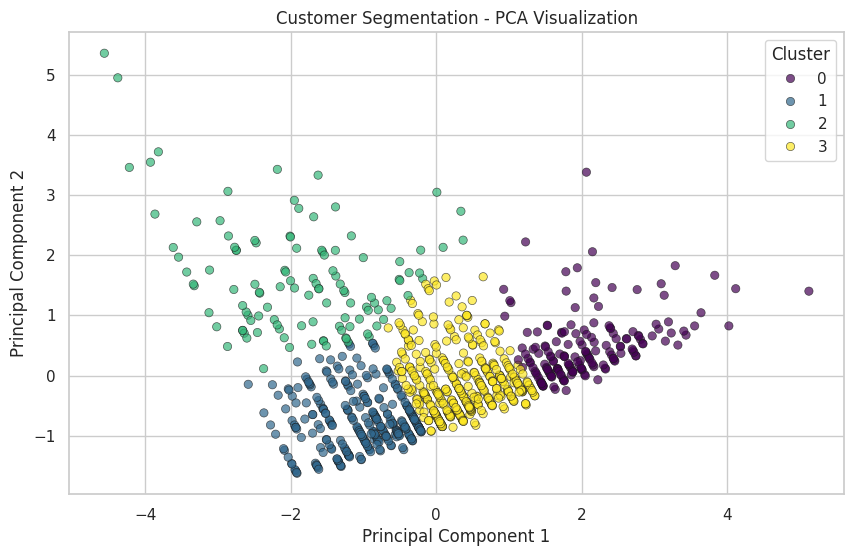

In [18]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(pca_data, columns=["PC1", "PC2"])
pca_df["Cluster"] = customer_features["cluster"]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=pca_df["Cluster"], palette="viridis", alpha=0.7, edgecolor="k")

# Customize plot
plt.title("Customer Segmentation - PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


pip install scikit-learn

In [19]:
!pip install scikit-learn

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')  # or strategy='median'
rfm_scaled_imputed = imputer.fit_transform(rfm_scaled)

# Apply K-Means clustering and add the 'Cluster' column to 'rfm'
optimal_k = 4  # Based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled_imputed)  # Use imputed data


In [20]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')  # or strategy='median'
rfm_scaled_imputed = imputer.fit_transform(rfm_scaled)

# Apply K-Means clustering and add the 'Cluster' column to 'rfm'
optimal_k = 4  # Based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled_imputed)  # Use imputed data


K-Means Silhouette Score

K-Means Silhouette Score: 0.1716


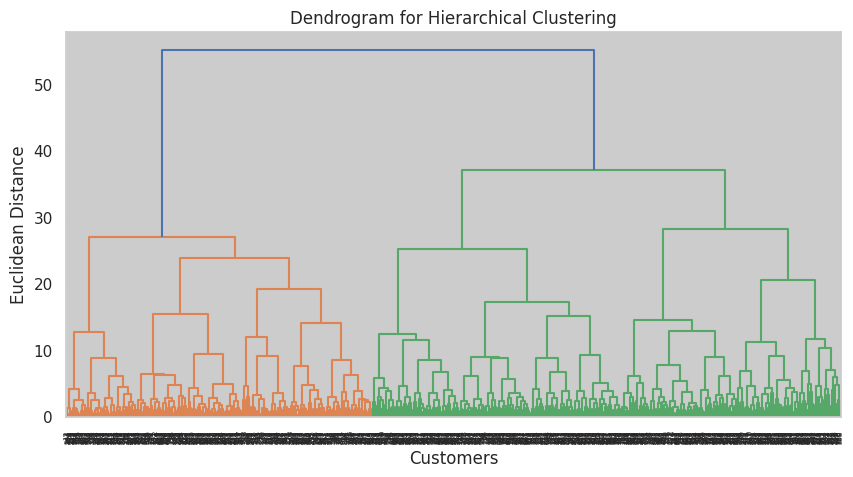

In [25]:


import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch  # Import sch

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')  # or strategy='median'
rfm_scaled_imputed = imputer.fit_transform(rfm_scaled)

# Apply K-Means clustering and add the 'Cluster' column to 'rfm'
optimal_k = 4  # Based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(rfm_scaled_imputed)  # Use imputed data for clustering
rfm['KMeans_Cluster'] = kmeans_labels

# Compute silhouette score for K-Means
kmeans_silhouette = silhouette_score(rfm_scaled_imputed, kmeans_labels)  # Use imputed data for silhouette score
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

# Hierarchical Clustering
# Use imputed data for hierarchical clustering as well
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled_imputed, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()


Segment Analysis

In [26]:
import pandas as pd

# Group customers by their assigned cluster and compute key statistics
cluster_summary = rfm.groupby("Cluster").agg(
    avg_Recency=("Recency", "mean"),  # Changed to 'Recency'
    avg_Frequency=("Frequency", "mean"),  # Changed to 'Frequency'
    avg_Monetary=("Monetary", "mean"),  # Changed to 'Monetary'
    customer_count=("Cluster", "count")  # Changed to 'Cluster'
).reset_index()

# Define segment descriptions and recommendations
def get_recommendations(cluster_id, avg_Monetary, avg_Frequency, avg_Recency):  # Changed parameter names
    if avg_Monetary > 0.75:  # Changed to 'avg_Monetary'
        return {
            "Segment": "Highly Engaged Coupon Users",
            "Recommendation": "Provide exclusive loyalty-based coupons and VIP discounts. Offer referral incentives."
        }
    elif avg_Frequency > 5:  # Changed to 'avg_Frequency'
        return {
            "Segment": "Frequent Shoppers, Moderate Coupon Use",
            "Recommendation": "Offer personalized discounts on frequently bought items. Introduce a tiered loyalty program."
        }
    elif avg_Monetary < 0.2:  # Changed to 'avg_Monetary'
        return {
            "Segment": "Low Engagement Customers",
            "Recommendation": "Send targeted email campaigns, offer higher discount coupons, and use limited-time offers."
        }
    else:
        return {
            "Segment": "Long-Term, Occasional Coupon Users",
            "Recommendation": "Provide seasonal or event-based coupons. Use bulk purchase incentives and reminders for expiring coupons."
        }

# Apply recommendations to each cluster
cluster_summary[["Segment", "Recommendation"]] = cluster_summary.apply(
    lambda row: pd.Series(get_recommendations(row["Cluster"], row["avg_Monetary"], row["avg_Frequency"], row["avg_Recency"])), axis=1  # Changed parameter names
)

# Display final segment analysis
print(cluster_summary)


   Cluster  avg_Recency  avg_Frequency  avg_Monetary  customer_count  \
0        0   130.165919       2.222222      0.927350             234   
1        1   404.293785       8.451977      4.627119             177   
2        2   361.303630       4.792079      2.943894             303   
3        3   394.930070       5.356643      2.055944             286   

                       Segment  \
0  Highly Engaged Coupon Users   
1  Highly Engaged Coupon Users   
2  Highly Engaged Coupon Users   
3  Highly Engaged Coupon Users   

                                      Recommendation  
0  Provide exclusive loyalty-based coupons and VI...  
1  Provide exclusive loyalty-based coupons and VI...  
2  Provide exclusive loyalty-based coupons and VI...  
3  Provide exclusive loyalty-based coupons and VI...  


Model Evaluation

<ipython-input-41-550dab0f7ebf>:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm["Recency"].fillna(rfm["Recency"].median(), inplace=True)
<ipython-input-41-550dab0f7ebf>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

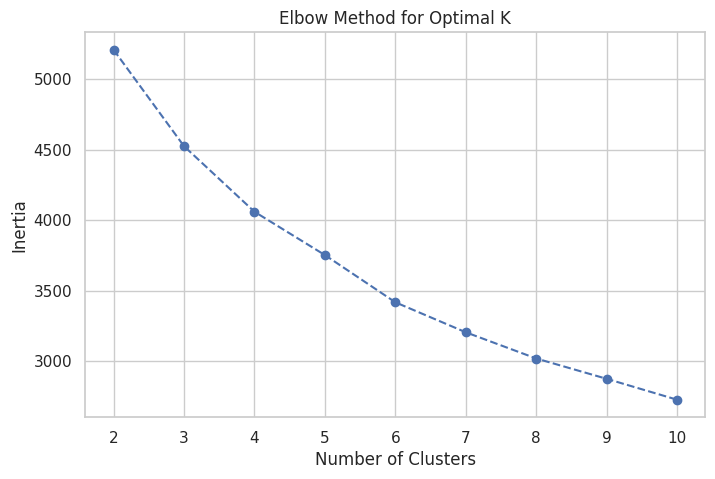

K-Means Silhouette Score: 0.1755


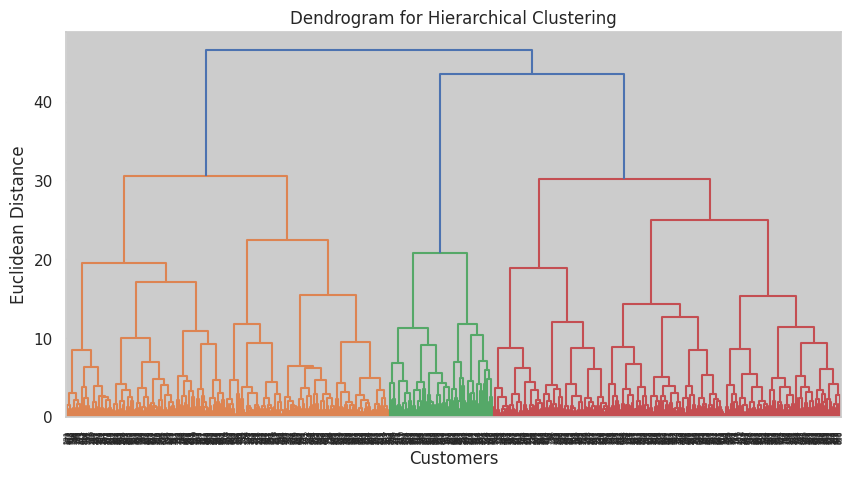

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

# Load dataset
file_path = "/content/E-commerce_data.xlsx"
xls = pd.ExcelFile(file_path)

# Load relevant sheets
customers = xls.parse("customers")
genders = xls.parse("genders")
cities = xls.parse("cities")
transactions = xls.parse("transactions")

# Merge datasets
data = customers.merge(genders.rename(columns={"gender_name": "gender"}), on="gender_id", how="left")\
                .merge(cities, on="city_id", how="left")\
                .merge(transactions, on="customer_id", how="left")

# Convert transaction date to datetime
data["transaction_date"] = pd.to_datetime(data["transaction_date"])

# Feature Engineering
rfm = data.groupby("customer_id").agg(
    Recency=("transaction_date", lambda x: (x.max() - x.min()).days),
    Frequency=("transaction_id", "count"),
    Monetary=("burn_date", lambda x: x.notna().sum()),
    Gender=("gender", "first"),
    City=("city_name", "first"),
    Coupon_Usage_Freq=("coupon_name", "count"),
    Transaction_Status=("transaction_status", "first")
).reset_index()

# Handle missing values
rfm["Recency"].fillna(rfm["Recency"].median(), inplace=True)
rfm["Frequency"].fillna(rfm["Frequency"].median(), inplace=True)
rfm["Monetary"].fillna(rfm["Monetary"].median(), inplace=True)
rfm["Coupon_Usage_Freq"].fillna(rfm["Coupon_Usage_Freq"].median(), inplace=True)
rfm["Gender"].fillna(rfm["Gender"].mode()[0], inplace=True)
rfm["City"].fillna(rfm["City"].mode()[0], inplace=True)
rfm["Transaction_Status"].fillna(rfm["Transaction_Status"].mode()[0], inplace=True)

# Encode categorical features
le_gender = LabelEncoder()
le_city = LabelEncoder()
le_status = LabelEncoder()
rfm["Gender"] = le_gender.fit_transform(rfm["Gender"])
rfm["City"] = le_city.fit_transform(rfm["City"])
rfm["Transaction_Status"] = le_status.fit_transform(rfm["Transaction_Status"])

# Standardize numerical features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary", "Gender", "City", "Coupon_Usage_Freq", "Transaction_Status"]])

# Determine optimal K using the Elbow Method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Train K-Means with optimal K (e.g., 4 clusters based on Elbow method observation)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(rfm_scaled)
rfm['KMeans_Cluster'] = kmeans_labels

# Compute silhouette score for K-Means
kmeans_silhouette = silhouette_score(rfm_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")

# Hierarchical Clustering
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()



Visualizations

<ipython-input-42-4f01de9ab860>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Cluster", y="customer_count", data=cluster_summary, palette="viridis") # Changed x to 'Cluster'


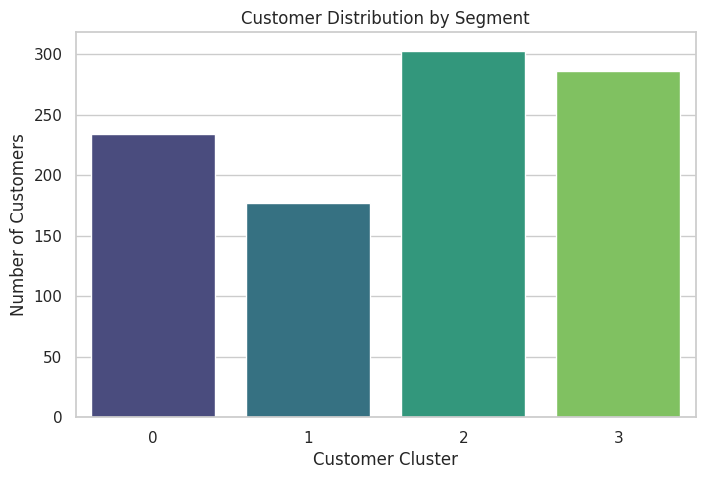

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# Bar chart: Customer count per cluster
plt.figure(figsize=(8, 5))
sns.barplot(x="Cluster", y="customer_count", data=cluster_summary, palette="viridis") # Changed x to 'Cluster'
plt.xlabel("Customer Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution by Segment")
plt.show()

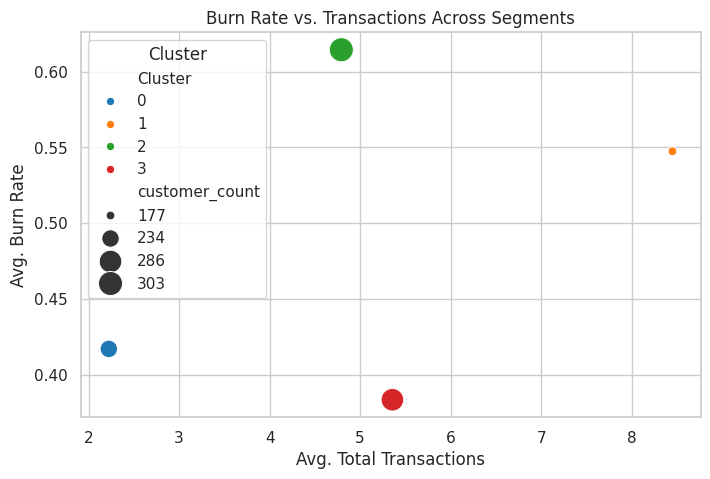

In [43]:
# Scatter plot: Burn Rate vs. Transactions by Cluster
cluster_summary["avg_total_transactions"] = cluster_summary["avg_Frequency"]
cluster_summary["avg_burn_rate"] = cluster_summary["avg_Monetary"] / cluster_summary["avg_Frequency"]

# Scatter plot: Burn Rate vs. Transactions by Cluster
plt.figure(figsize=(8, 5))
sns.scatterplot(x="avg_total_transactions", y="avg_burn_rate", hue="Cluster", size="customer_count",  # Changed hue to "Cluster"
                data=cluster_summary, palette="tab10", sizes=(40, 300))
plt.xlabel("Avg. Total Transactions")
plt.ylabel("Avg. Burn Rate")
plt.title("Burn Rate vs. Transactions Across Segments")
plt.legend(title="Cluster")
plt.show()

<ipython-input-44-91b98702559c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="avg_tenure_days", data=cluster_summary, palette="coolwarm", ax=axes[0])
<ipython-input-44-91b98702559c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="avg_total_transactions", data=cluster_summary, palette="coolwarm", ax=axes[1])


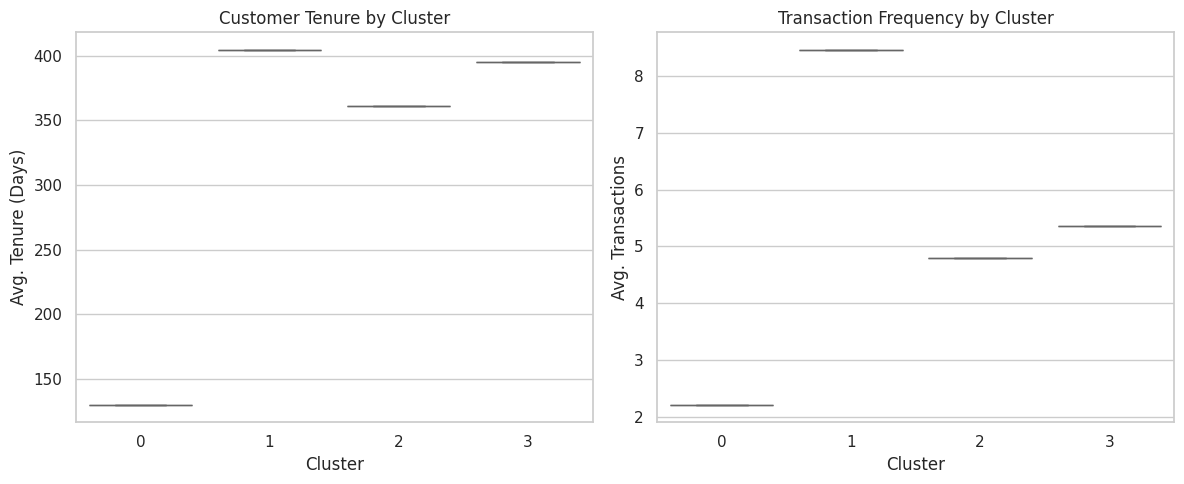

In [44]:
# Boxplots: Tenure & Transactions by Cluster
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Calculate avg_tenure_days (assuming 'Recency' represents tenure)
cluster_summary["avg_tenure_days"] = cluster_summary["avg_Recency"]

# Now you can use 'avg_tenure_days' in the boxplot
sns.boxplot(x="Cluster", y="avg_tenure_days", data=cluster_summary, palette="coolwarm", ax=axes[0])
axes[0].set_title("Customer Tenure by Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Avg. Tenure (Days)")

sns.boxplot(x="Cluster", y="avg_total_transactions", data=cluster_summary, palette="coolwarm", ax=axes[1])
axes[1].set_title("Transaction Frequency by Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Avg. Transactions")

plt.tight_layout()
plt.show()